In [1]:
!pip install keras==2.6

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

# For preprocessing
import re 
import nltk
import string
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import SnowballStemmer
import pickle
from collections import Counter  #to count elements in list

# For Building the model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import ticker
%matplotlib inline
import seaborn as sns

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Reading the dataset

In [3]:
df = pd.read_csv('/kaggle/input/se2015-restaurants/restaurants.csv')

# Final Cleaning

In [4]:
df['text'] = df['text'].str.replace('\d+', '')
df["text"] = df["text"].str.replace("?"," ")
df["text"] = df["text"].str.replace("!"," ")
df["text"] = df["text"].str.replace("_"," ")
df["text"] = df["text"].str.replace(","," ")
df["text"] = df["text"].str.replace("&"," ")
df["text"] = df["text"].str.replace("\n"," ")
df["text"] = df["text"].str.replace("/"," ")
df["text"] = df["text"].str.replace("-"," ")
df["text"] = df["text"].str.replace("$"," ")
df["text"] = df["text"].str.replace("\r"," ")
df["text"] = df["text"].str.replace("."," ")
df["text"] = df["text"].str.replace("~"," ")
df["text"] = df["text"].str.replace("["," ")
df["text"] = df["text"].str.replace("]"," ")

In [5]:
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [6]:
df['text'].isna().sum()

0

In [7]:
def text_to_words(text):
# tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [8]:
X = list(map(text_to_words, df['text']))
len(X)

1654

In [9]:
df['polarity'][df["polarity"] == 'negative'] = 0
df['polarity'][df["polarity"] == 'positive'] = 1
df['polarity'][df["polarity"] == 'neutral'] = 2

In [10]:
df.head()

,text,target,category,polarity,from,to
0,Judging previous posts used good place longer,place,RESTAURANT#GENERAL,0,51,56
1,We four us arrived noon place empty staff acte...,staff,SERVICE#GENERAL,0,75,80
2,They never brought us complimentary noodles ig...,NaN,SERVICE#GENERAL,0,0,0
3,The food lousy sweet salty portions tiny,food,FOOD#QUALITY,0,4,8
4,The food lousy sweet salty portions tiny,portions,FOOD#STYLE_OPTIONS,0,52,60


In [11]:
df = df.drop(['from','to'], axis = 1)

In [12]:
df.head()

,text,target,category,polarity
0,Judging previous posts used good place longer,place,RESTAURANT#GENERAL,0
1,We four us arrived noon place empty staff acte...,staff,SERVICE#GENERAL,0
2,They never brought us complimentary noodles ig...,NaN,SERVICE#GENERAL,0
3,The food lousy sweet salty portions tiny,food,FOOD#QUALITY,0
4,The food lousy sweet salty portions tiny,portions,FOOD#STYLE_OPTIONS,0


In [13]:
df['polarity'].unique()

array([0, 1, 2], dtype=object)

In [14]:
# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['polarity'])

In [15]:
# Train and test split
y = pd.get_dummies(df['polarity'])
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, 
                                                  random_state=1)

# Bag of words (BOW) feature extraction

In [16]:
vocabulary_size = len(X)

count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

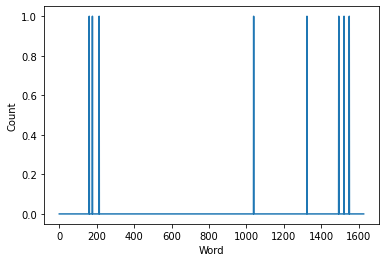

In [17]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

In [18]:
df.shape

(1654, 4)

In [19]:
print(len(df))

1654


In [20]:
print(df.index)

RangeIndex(start=0, stop=1654, step=1)


In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = vocabulary_size
max_len=32 # since average tweet is 28 characters long

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['text'][1651])
X, tokenizer = tokenize_pad_sequences(df['text'])
print('After Tokenization & Padding \n', X[1651])

Before Tokenization & Padding 
 Luckily saved room BBQ Salmon Sea Bass Crispy Duck
After Tokenization & Padding 
 [1017 1018  161  418  261  434  728  351  430    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [22]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [23]:
## Traintest split

y = pd.get_dummies(df['polarity'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (1058, 32) (1058, 3)
Validation Set -> (265, 32) (265, 3)
Test Set -> (331, 32) (331, 3)


In [24]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# BiLSTM with attention

In [25]:
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import RMSprop
#from keras import datasets

# from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from tensorflow.keras import losses

In [26]:
class Position_Embedding(Layer):
    
    def __init__(self, size=None, mode='sum', **kwargs):
        self.size = size
        self.mode = mode
        super(Position_Embedding, self).__init__(**kwargs)
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'size': self.size,
            'mode': self.mode
        })
        return config    
        
    def call(self, x):
        if (self.size == None) or (self.mode == 'sum'):
            self.size = int(x.shape[-1])
        batch_size,seq_len = K.shape(x)[0],K.shape(x)[1]
        position_j = 1. / K.pow(10000., \
                                 2 * K.arange(self.size / 2, dtype='float32' \
                               ) / self.size)
        position_j = K.expand_dims(position_j, 0)
        position_i = K.cumsum(K.ones_like(x[:,:,0]), 1)-1 
        position_i = K.expand_dims(position_i, 2)
        position_ij = K.dot(position_i, position_j)
        position_ij = K.concatenate([K.cos(position_ij), K.sin(position_ij)], 2)
        if self.mode == 'sum':
            return position_ij + x
        elif self.mode == 'concat':
            return K.concatenate([position_ij, x], 2)
        
    def compute_output_shape(self, input_shape):
        if self.mode == 'sum':
            return input_shape
        elif self.mode == 'concat':
            return (input_shape[0], input_shape[1], input_shape[2]+self.size)


'''
output dimention: [batch_size, time_step, nb_head*size_per_head]
every word can be represented as a vector [nb_head*size_per_head]
'''
class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [27]:
vocab_size = len(X)
embedding_size = 300

model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='softmax'))
#model2.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Position_Embedding())
model.add(attention(return_sequences=True)) # receive 3D and output 3D
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 300)           496200    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 32, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 256)           230656    
_________________________________________________________________
bidirectional (Bidirectional (None, 32, 256)           394240    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32, 256)           394240    
_________________________________________________________________
position__embedding (Positio (None, 32, 256)           0         
_________________________________________________________________
attention (attention)        (None, 32, 256)           2

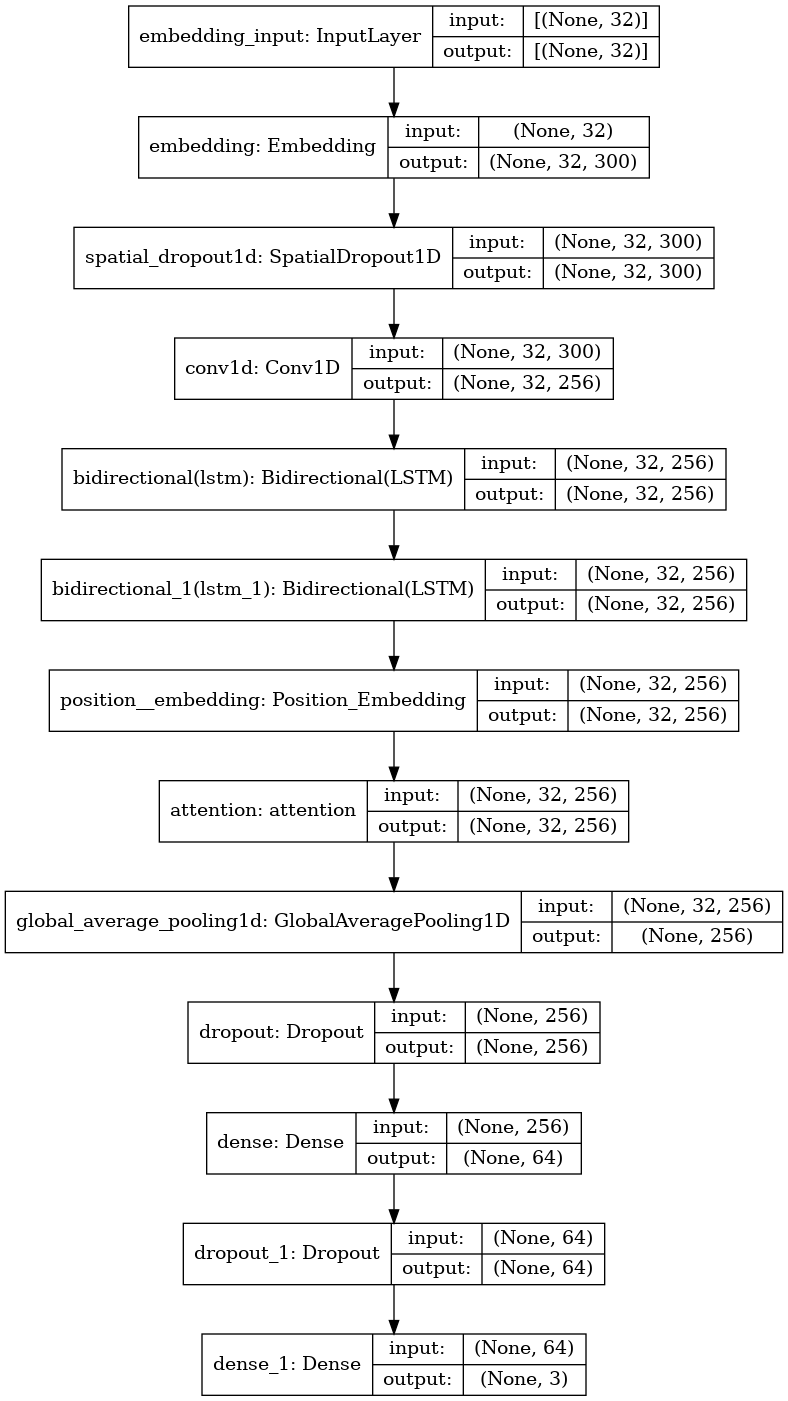

In [28]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

#  Compile model

In [29]:
learning_rate = 0.001

opt = RMSprop(lr=learning_rate)
#opt2 = Adam(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=opt, 
               metrics=['accuracy',Precision(), Recall()])

In [30]:
import warnings
warnings.filterwarnings("ignore")

# Training the model

In [31]:
from keras.callbacks import Callback, EarlyStopping
#early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
batch_size = 8
epochs=100
history2 = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, 
                      epochs=epochs,
                      shuffle=True,
                       verbose=1)
#                      callbacks=[early_stop])

Epoch 1/100
133/133 [==============================] - 18s 31ms/step - loss: 0.7367 - accuracy: 0.7060 - precision: 0.7146 - recall: 0.6484 - val_loss: 0.7102 - val_accuracy: 0.7283 - val_precision: 0.7283 - val_recall: 0.7283
Epoch 2/100
133/133 [==============================] - 2s 18ms/step - loss: 0.7022 - accuracy: 0.7136 - precision: 0.7136 - recall: 0.7136 - val_loss: 0.7198 - val_accuracy: 0.7283 - val_precision: 0.7283 - val_recall: 0.7283
Epoch 3/100
133/133 [==============================] - 2s 18ms/step - loss: 0.7011 - accuracy: 0.7136 - precision: 0.7136 - recall: 0.7136 - val_loss: 0.7138 - val_accuracy: 0.7283 - val_precision: 0.7283 - val_recall: 0.7283
Epoch 4/100
133/133 [==============================] - 2s 16ms/step - loss: 0.7040 - accuracy: 0.7136 - precision: 0.7136 - recall: 0.7136 - val_loss: 0.7178 - val_accuracy: 0.7283 - val_precision: 0.7283 - val_recall: 0.7283
Epoch 5/100
133/133 [==============================] - 2s 16ms/step - loss: 0.7034 - accuracy: 

# Evaluate model on the test set

In [32]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.6737
Precision : 0.7115
Recall    : 0.6707
F1 Score  : 0.6905


# Save the model architecture & the weights

In [33]:
# model.save('model.h5')
# print('Model saved')

# Loaing the model

In [34]:
# from keras.models import load_model

# # Load model
# model = load_model('model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = [-1, 0, 1]
    max_len=32
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [35]:
predict_class(['government stop crypto trading, future of crypto is in trouble'])

The predicted sentiment is 1


## Datasets going to use in future

https://www.kaggle.com/datasets/shivamb/go-emotions-google-emotions-dataset

https://www.kaggle.com/datasets/avisheksood/stock-news-sentiment-analysismassive-dataset

https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-in-commodity-market-gold

https://www.kaggle.com/datasets/ankurzing/aspect-based-sentiment-analysis-for-financial-news

https://www.kaggle.com/datasets/kazanova/sentiment140

# References

[How Positional Embeddings work in Self-Attention](https://theaisummer.com/positional-embeddings/)